# QAOA with Classiq and Cuda-Q

This notebooks shows how to create a high level QAOA circuit using Classiq and execute this using NVIDIA's Cuda-q.
Some handy resources: 
 - [The QAOA example in the Classiq library](https://github.com/Classiq/classiq-library/blob/0.73.0/applications/optimization/max_cut/max_cut.ipynb), this will give a more detailed explanation of the different steps using Pyomo.
 - [QAOA example using Cuda-Q](https://nvidia.github.io/cuda-quantum/0.10.0/applications/python/qaoa.html)

 First install the needed packages

In [ ]:
!pip install cudaq==0.10.0
!pip install classiq==0.74.0

In [ ]:
import cudaq
from cudaq import spin
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from classiq import *
import math, random
from classiq.applications.combinatorial_optimization import pyo_model_to_hamiltonian, QAOAConfig
import pyomo.core as pyo
import re

### Login to Classiq

If you have not yet authenticated make sure that you login, you can do this by uncommenting the line below. If you do not yt have a Classiq account make sure you singup [here](https://platform.classiq.io/).

In [ ]:
#authenticate(overwrite=True)

### Create the problem

In [ ]:
# Classiq code
# Create graph

G = nx.Graph()
nodes = [0, 1, 2, 3, 4]
edges = [[0, 1], [1, 2], [2, 3], [3, 0], [2, 4], [3, 4]]

G.add_nodes_from(nodes)
G.add_edges_from(edges)

pos = nx.planar_layout(G)
nx.draw_networkx(G, pos=pos, with_labels=True, alpha=0.8, node_size=500)

In [ ]:
# Number of layers in the QAOA circuit
NUM_LAYERS = 1

The hamiltonian format that Classiq uses and NVIDIA uses are diffrent, therefore we will need to map the Classiq hamiltonian to one that can be used by Cuda-Q. 
This will be used later in the notebook.

In [17]:
my_list = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}

def enums_to_pauli_str(pauli_enums):
    inverse_list = {v: k for k, v in my_list.items()}
    return ''.join(inverse_list[p] for p in pauli_enums)

def hamiltonian_to_pauli_list(hamiltonian):
    return [
        (enums_to_pauli_str(term.pauli), term.coefficient.real)
        for term in hamiltonian
    ]

def classiq_hamiltonian_to_cudaq_spinOperator(hamiltonian):
    pauli_list = hamiltonian_to_pauli_list(hamiltonian)

    spin_hamiltonian = 0
    for pauli in pauli_list:
        spin_hamiltonian += (pauli[1] * cudaq.SpinOperator.from_word(pauli[0]))

    return spin_hamiltonian

Create the Pyomo model for the Max-cut problem

In [ ]:
def arithmetic_eq(x1: int, x2: int) -> int:
    return x1 * (1 - x2) + x2 * (1 - x1)


# we define a function which returns the pyomo model for a graph input
def maxcut(graph: nx.Graph) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel()
    model.x = pyo.Var(graph.nodes, domain=pyo.Binary)

    model.cost = pyo.Objective(
        expr=sum(
            arithmetic_eq(model.x[node1], model.x[node2])
            for (node1, node2) in graph.edges
        ),
        sense=pyo.maximize,
    )

    return model

maxcut_model = maxcut(G)
classiq_hamiltonian = pyo_model_to_hamiltonian(maxcut_model, penalty_energy=2)
hamiltonian = classiq_hamiltonian_to_cudaq_spinOperator(classiq_hamiltonian)

# print(hamiltonian)
# print(classiq_hamiltonian)

Using the synthesis command, Classiq will create a gate based circuit from the max-cut model that was created using Pyomo.

In [19]:
qaoa_config = QAOAConfig(num_layers=NUM_LAYERS)

qmod = construct_combinatorial_optimization_model(
    pyo_model=maxcut_model,
    qaoa_config=qaoa_config,
)

qprog = synthesize(qmod)
# show(qprog)

We will grab the QASM representation of the circuit. To later transform into a Cuda-Q kernel

In [ ]:
qprogram = QuantumProgram.from_qprog(qprog)
raw_qasm = qprogram.transpiled_circuit.qasm

qasm_lines = raw_qasm.splitlines()
# print(qasm_lines)

This function will translate the QASM circuit into a Cuda-Q Kernel.

In [ ]:
qaoa_kernel, params = cudaq.make_kernel(list[float])
qubits = qaoa_kernel.qalloc(qprogram.data.width)

for line in qasm_lines:
    line = line.strip().strip(";")

    # Parse gates with parameters like rz(0.25*params_param_0)
    param_gate_match = re.match(r"(rz|rx)\((.+)\) q\[(\d+)\]", line)
    if param_gate_match:
        gate, param, qubit = param_gate_match.groups()
        param_index = int(param[-1])
        if(gate == "rz"):
            qaoa_kernel.rz(params[param_index] * float(param.split("*")[0]),qubits[int(qubit)])

        elif(gate == "rx"):
            qaoa_kernel.rx(params[param_index],qubits[int(qubit)])

        continue

    # Parse gates without parameters: h, cx
    simple_gate_match = re.match(r"(h|cx) q\[(\d+)\](, q\[(\d+)\])?", line)
    if simple_gate_match:
        gate, q1, _, q2 = simple_gate_match.groups()
        if(gate == "h"):
            qaoa_kernel.h(qubits[int(q1)])
        args = [f"q[{q1}]"]
        if q2:
            qaoa_kernel.cx(qubits[int(q1)],qubits[int(q2)])

In [ ]:
# print(cudaq.draw(qaoa_kernel,[0.1]* qprogram.data.width))

With Cuda-Q kerel and the right format hamiltonian we can now run the optimization to solve the max-cut progblem using Cuda-Q.

In [ ]:
# cudaq.set_target('nvidia') # If you have access to a GPU you can use this
cudaq.set_target('qpp-cpu')

qubit_count: int = qprogram.data.width
parameter_count: int = 2 * NUM_LAYERS
energies = []

# Specify the optimizer and its initial parameters. Make it repeatable.
# cudaq.set_random_seed(13)
optimizer = cudaq.optimizers.COBYLA()
optimizer.max_iterations = 30
optimizer.initial_parameters = [random.uniform(-math.pi / 8.0, math.pi / 8.0) for _ in range(parameter_count)]
print("Initial parameters = ", optimizer.initial_parameters)

# Define the objective, return `<state(params) | H | state(params)>`
def objective(parameters):
    energy = cudaq.observe(qaoa_kernel, hamiltonian, parameters).expectation()
    energies.append(energy)
    return energy

# Optimize!
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective)

# Print the optimized value and its parameters
print("Optimal value = ", optimal_expectation)
print("Optimal parameters = ", optimal_parameters)

# Sample the circuit using the optimized parameters
counts = cudaq.sample(qaoa_kernel, optimal_parameters)
print(counts)

Execute the circuit with the optimal parameters to look at the solution that is measured most.

In [ ]:
large_counts = cudaq.sample(qaoa_kernel, optimal_parameters, shots_count=200000)

sorted_items = sorted(large_counts.items(), key=lambda item: item[1], reverse=True)

# Print the top 5 entries
for key, value in sorted_items[:5]:
    print(f"{key}: {value}")

Plot the convergence 

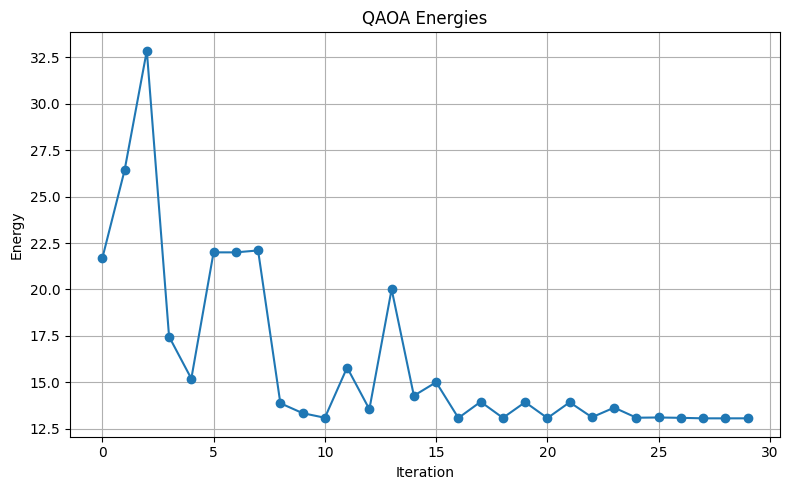

In [32]:
import matplotlib.pyplot as plt

def plot_energies(energies):
    plt.figure(figsize=(8, 5))
    plt.plot(energies, marker='o')
    plt.title("QAOA Energies")
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_energies(energies=energies)